## Data Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import multivariate_normal
np.random.seed(42)


Function to generate data from a ground truth model with K classes and η-dependent covariance

In [2]:
import numpy as np

def generate_data(n_per_class, eta, K, means, shared_cov, class_covs):
    
    X_list, y_list = [], [] # Use _list suffix to clearly indicate they are lists of arrays

    for i in range(K):
        # Calculate the blended covariance matrix based on eta
        cov = (1 - eta) * shared_cov + eta * class_covs[i]
        
        # Add a small epsilon to the diagonal for numerical stability
        # This helps prevent LinAlgError due to singular or non-positive definite matrices
        #epsilon = 1e-6 
        #cov = cov + np.eye(cov.shape[0]) * epsilon
        
        # Generate multivariate normal samples for the current class
        X_list.append(np.random.multivariate_normal(means[i], cov, size=n_per_class))
        y_list.append(np.full(n_per_class, i))
    
    # Vertically stack all class feature arrays into a single data matrix
    X = np.vstack(X_list)
    # Horizontally stack all class label arrays into a single label vector
    y = np.hstack(y_list)
    
    # Permute the data to ensure samples from different classes are interleaved
    # This is important for robust splitting and training
    rng = np.random.default_rng(seed=42)
    perm = rng.permutation(len(y))

    X = X[perm]
    y = y[perm]
    
    return X, y

Base simulation setup
- Create smooth class covariance matrices with varying correlations
- Correlation smoothly varies between -1 and 1

In [ ]:
def setup_simulation(K, eta, n_train, print_covariances=False):
    np.random.seed(1)

    # Arrange class means in a grid pattern
    means = [np.array([i * 2, j * 2])
             for i in range(int(np.ceil(K**0.5)))
             for j in range(int(np.ceil(K**0.5)))]
    means = means[:K]

    shared_cov = np.array([[1, 0], [0, 1]])  # Identity
    n_per_class = n_train // K

    # Generate distinct elliptical and rotated covariances
    class_covs = []
    for k in range(K):
        angle = (np.pi / K) * k  # unique angle per class
        rotation = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle),  np.cos(angle)]
        ])
        scales = np.diag([1.0 + 0.5 * k, 0.3 + 0.2 * (K - k)])  # different eigenvalues
        cov_k = rotation @ scales @ rotation.T
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)  # ensure symmetry & stability
        class_covs.append(cov_k)

    # Generate data
    X_train, y_train = generate_data(n_per_class=n_per_class, eta=eta, K=K,
                                     means=means, shared_cov=shared_cov, class_covs=class_covs)

    X_train, y_train = shuffle(X_train, y_train, random_state=1)
    # Optionally print empirical covariances
    if print_covariances:
        print(f"\nEmpirical covariance matrices (η = {eta}):")
        for i in range(K):
            X_class = X_train[y_train == i]
            if len(X_class) > 1:
                cov = np.cov(X_class, rowvar=False)
                print(f"Class {i}:\n{cov}\n")
            else:
                print(f"Class {i}: Not enough samples to compute empirical covariance.\n")

    return X_train, y_train, means, shared_cov, class_covs

In [ ]:
def setup_simulation_new(K, eta, n_train, print_covariances=False):
    np.random.seed(42)

    means = [np.array([i * 2, j * 2]) 
             for i in range(int(np.ceil(K**0.5))) 
             for j in range(int(np.ceil(K**0.5)))]
    means = means[:K]

    shared_cov = np.array([[1.0, 0.0], [0.0, 1.0]])  # Keep for Bayes blending
    
    n_per_class = n_train // K

    class_covs = []
    for k in range(K):
        angle = np.pi / 4 * k  # Distinct rotation for each class
        rotation = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle),  np.cos(angle)]
        ])
        # Strong anisotropy with different eigenvalues
        scales = np.diag([1.0 + k, 0.2 + 0.3 * (K - k)])  
        cov_k = rotation @ scales @ rotation.T
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)  # Symmetric & stable
        class_covs.append(cov_k)

    X_train, y_train = generate_data(
        n_per_class=n_per_class,
        eta=eta,
        K=K,
        means=means,
        shared_cov=shared_cov,
        class_covs=class_covs
    )

    if print_covariances:
        print(f"\nEmpirical covariance matrices (η = {eta}):")
        for i in range(K):
            X_class = X_train[y_train == i]
            cov = np.cov(X_class, rowvar=False)
            print(f"Class {i}:\n{cov}\n")

    return X_train, y_train, means, shared_cov, class_covs


## Models

Function to compute Bayes classifier predictions

In [5]:
def compute_bayes_predictions(X, means, shared_cov, class_covs, eta):
    K = len(means)
    n = X.shape[0]
    probs = np.zeros((n, K))
    priors = np.full(K, 1.0 / K)  # uniform priors


    for k in range(K):
        sigma_k = (1 - eta) * shared_cov + eta * class_covs[k]
        sigma_k = (sigma_k + sigma_k.T) / 2  # enforce symmetry
        sigma_k += np.eye(sigma_k.shape[0]) * 1e-6  # add epsilon for numerical stability

        rv = multivariate_normal(mean=means[k], cov=sigma_k)
        probs[:, k] = rv.pdf(X) * priors[k]

    probs /= probs.sum(axis=1, keepdims=True)
    predictions = np.argmax(probs, axis=1)
    return predictions, probs


In [6]:
import numpy as np
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def compute_lda_predictions(X_train, y_train, X_test):
    model = LinearDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model


In [7]:

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def compute_qda_predictions(X_train, y_train, X_test):
    model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model



- Estimate means from training data
- Generate test data using the same method (or use part of train data as test)
- Estimate shared covariance (pooled estimate for LDA)
- Estimate class-specific covariances (for QDA and Bayes)
- Run predictions

In [8]:
import numpy as np
from scipy.stats import multivariate_normal

# Parameters
k = 3
eta = 0.1
n_train = 20

# Generate training data and get true parameters
X_train, y_train, means_true, shared_cov_true, class_covs_true = setup_simulation(k, eta, n_train)

means_est = [X_train[y_train == k].mean(axis=0) for k in range(k)]
shared_cov_est = np.cov(X_train.T)
class_covs_est = [np.cov(X_train[y_train == k].T) for k in range(k)]

# Generate test data using the same parameters from training
n_test_per_class = 25 
X_test, y_test = generate_data(n_per_class=n_test_per_class, eta=eta, K=k,
                               means=means_true,
                               shared_cov=shared_cov_true,
                               class_covs=class_covs_true)

# Predict using LDA, QDA, and Bayes classifiers
preds_lda, probs_lda, lda_model = compute_lda_predictions(X_train, y_train, X_test)
preds_qda, probs_qda, qda_model = compute_qda_predictions(X_train, y_train, X_test)
preds_bayes, probs_bayes = compute_bayes_predictions(X_test, means_est, shared_cov_est, class_covs_est, eta)

# Accuracy function
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

print("LDA Accuracy:", accuracy(y_test, preds_lda))
print("QDA Accuracy:", accuracy(y_test, preds_qda))
print("Bayes Accuracy:", accuracy(y_test, preds_bayes))


LDA Accuracy: 0.76
QDA Accuracy: 0.6666666666666666
Bayes Accuracy: 0.7733333333333333


# PLOT

Draw confidence ellipses

In [9]:
def draw_ellipses(ax, means, shared_cov, class_covs, eta):
    for i, mean in enumerate(means):
        cov = (1 - eta) * shared_cov + eta * class_covs[i]
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * vals)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor='black', fc='None', lw=2)
        ax.add_patch(ellip)

Function to plot LDA, QDA, and Bayes boundaries

In [10]:
"""def visualize_boundaries(X_train, y_train, X_test, y_test,
                         means_true, shared_cov_true, class_covs_true,
                         means_est, shared_cov_est, class_covs_est,
                         preds_lda, preds_qda, preds_bayes,
                         lda_model, qda_model, eta):

    # Set up mesh grid
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Compute probability predictions instead of class labels
    _, _,  lda_model = compute_lda_predictions(X_train, y_train, grid)
    _, _,  qda_model = compute_qda_predictions(X_train, y_train, grid)
    _, probs_bayes_grid = compute_bayes_predictions(grid, means_est, shared_cov_est, class_covs_est, eta)


    Z_lda_prob = lda_model.predict_proba(grid)[:, 1].reshape(xx.shape)
    Z_qda_pred = qda_model.predict(grid).reshape(xx.shape)

    Z_bayes_prob = probs_bayes_grid[:, 1].reshape(xx.shape)

    # Class prediction for background coloring
    Z_qda_class = qda_model.predict(grid).reshape(xx.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(xx, yy, Z_qda_class, alpha=0.1)

    # Plot decision boundaries at p = 0.5
    ax.contour(xx, yy, Z_qda_pred, levels=[0.5], colors='green', linewidths=2)
    ax.contour(xx, yy, Z_bayes_prob, levels=[0.5], colors='purple', linestyles='--', linewidths=2)
    ax.contour(xx, yy, Z_lda_prob, levels=[0.5], colors='black', linestyles=':', linewidths=2)

    # Plot test points
    for i in range(len(np.unique(y_train))):
        ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                   s=30, label=f"Class {i}", alpha=0.6)

    # Draw true ellipses
    #draw_ellipses(ax, means_true, shared_cov_true, class_covs_true, eta)

    # Accuracy scores
    def accuracy(y_true, y_pred): return np.mean(y_true == y_pred)
    acc_lda = accuracy(y_test, preds_lda)
    acc_qda = accuracy(y_test, preds_qda)
    acc_bayes = accuracy(y_test, preds_bayes)

    # Title and legend
    ax.set_title(f"QDA vs Bayes vs LDA (η = {eta})\n"
                 f"LDA: {acc_lda:.2f}, QDA: {acc_qda:.2f}, Bayes: {acc_bayes:.2f}")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

    custom_lines = [Line2D([0], [0], color='green', linestyle='-'),
                    Line2D([0], [0], color='purple', linestyle='--'),
                    Line2D([0], [0], color='black', linestyle=':')]
    ax.legend(custom_lines, ['QDA Boundary', 'Bayes Boundary', 'LDA Boundary'], loc='upper right')

    plt.tight_layout()
    plt.show()
"""

'def visualize_boundaries(X_train, y_train, X_test, y_test,\n                         means_true, shared_cov_true, class_covs_true,\n                         means_est, shared_cov_est, class_covs_est,\n                         preds_lda, preds_qda, preds_bayes,\n                         lda_model, qda_model, eta):\n\n    # Set up mesh grid\n    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1\n    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),\n                         np.linspace(y_min, y_max, 300))\n    grid = np.c_[xx.ravel(), yy.ravel()]\n\n    # Compute probability predictions instead of class labels\n    _, _,  lda_model = compute_lda_predictions(X_train, y_train, grid)\n    _, _,  qda_model = compute_qda_predictions(X_train, y_train, grid)\n    _, probs_bayes_grid = compute_bayes_predictions(grid, means_est, shared_cov_est, class_covs_est, eta)\n\n\n    Z_lda_prob = lda_model.predict_proba(grid

In [11]:
def visualize_boundaries(X_train, y_train, X_test, y_test,
                         means_true, shared_cov_true, class_covs_true,
                         means_est, shared_cov_est, class_covs_est,
                         preds_lda, preds_qda, preds_bayes,
                         lda_model, qda_model, eta):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # Set up mesh grid
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict class labels over grid
    Z_lda = lda_model.predict(grid).reshape(xx.shape)
    Z_qda = qda_model.predict(grid).reshape(xx.shape)
    Z_bayes, _ = compute_bayes_predictions(grid, means_est, shared_cov_est, class_covs_est, eta)
    Z_bayes = Z_bayes.reshape(xx.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Background: QDA class predictions
    ax.contourf(xx, yy, Z_qda, alpha=0.1)

    # Plot decision boundaries between classes
    levels = np.arange(len(np.unique(y_train)) + 1) - 0.5
    ax.contour(xx, yy, Z_qda, levels=levels, colors='green', linewidths=2)
    ax.contour(xx, yy, Z_bayes, levels=levels, colors='purple', linestyles='--', linewidths=2)
    ax.contour(xx, yy, Z_lda, levels=levels, colors='black', linestyles=':', linewidths=2)

    # Plot test points
    for i in range(len(np.unique(y_train))):
        ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                   s=30, label=f"Class {i}", alpha=0.6)

    # Accuracy scores
    def accuracy(y_true, y_pred): return np.mean(y_true == y_pred)
    acc_lda = accuracy(y_test, preds_lda)
    acc_qda = accuracy(y_test, preds_qda)
    acc_bayes = accuracy(y_test, preds_bayes)

    # Title and labels
    ax.set_title(f"QDA vs Bayes vs LDA (η = {eta})\n"
                 f"LDA: {acc_lda:.2f}, QDA: {acc_qda:.2f}, Bayes: {acc_bayes:.2f}")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

    # Custom legend
    custom_lines = [Line2D([0], [0], color='green', linestyle='-'),
                    Line2D([0], [0], color='purple', linestyle='--'),
                    Line2D([0], [0], color='black', linestyle=':')]
    ax.legend(custom_lines, ['QDA Boundary', 'Bayes Boundary', 'LDA Boundary'], loc='upper right')

    plt.tight_layout()
    plt.show()


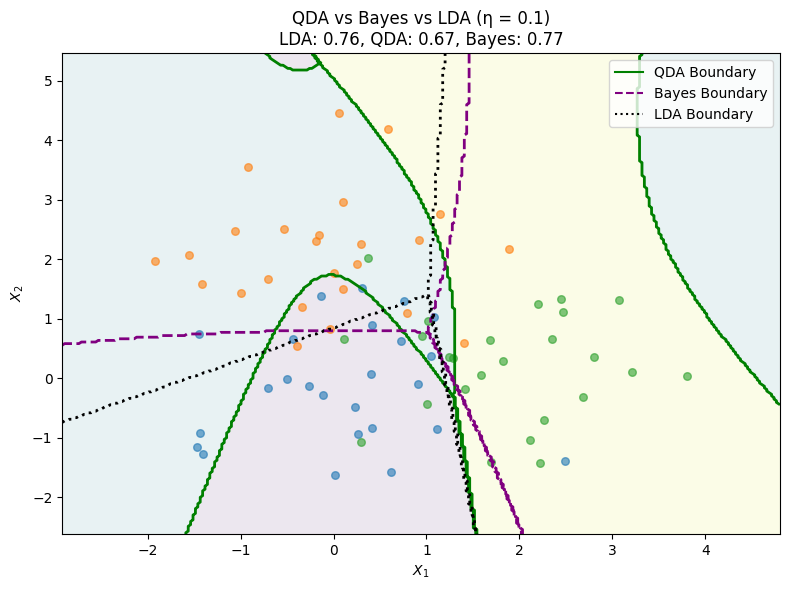

In [12]:
visualize_boundaries(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    means_true=means_true,
    shared_cov_true=shared_cov_true,
    class_covs_true=class_covs_true,
    means_est=means_est,
    shared_cov_est=shared_cov_est,
    class_covs_est=class_covs_est,
    preds_lda=preds_lda,
    preds_qda=preds_qda,
    preds_bayes=preds_bayes,
    lda_model=lda_model,
    qda_model=qda_model,
    eta=eta
)


## Function to run full simulation, fit, and plotting

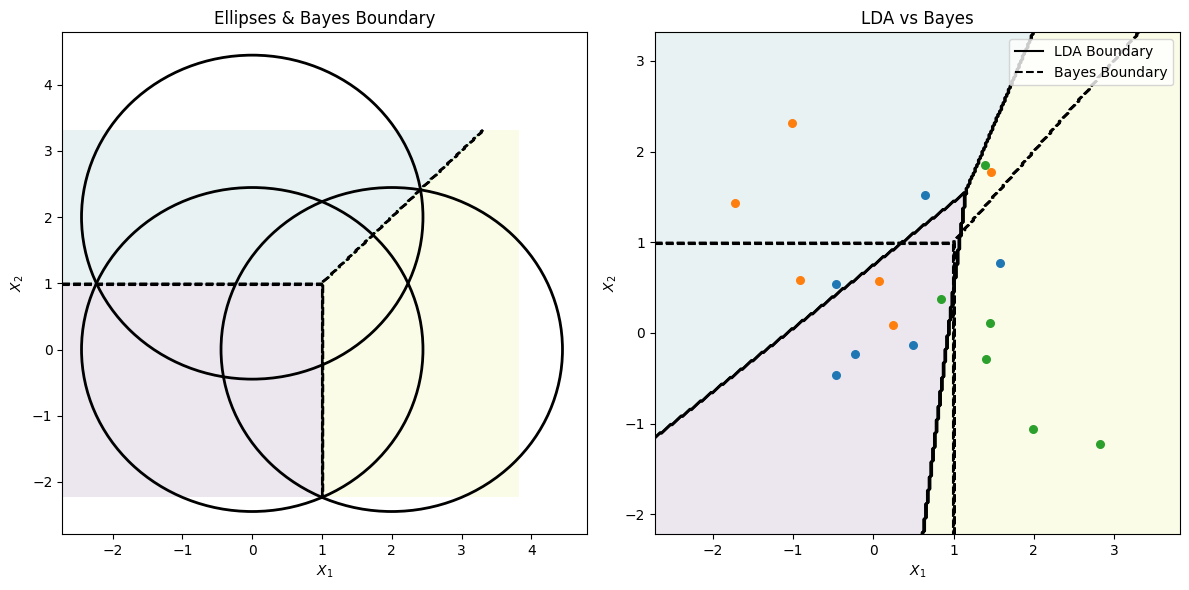

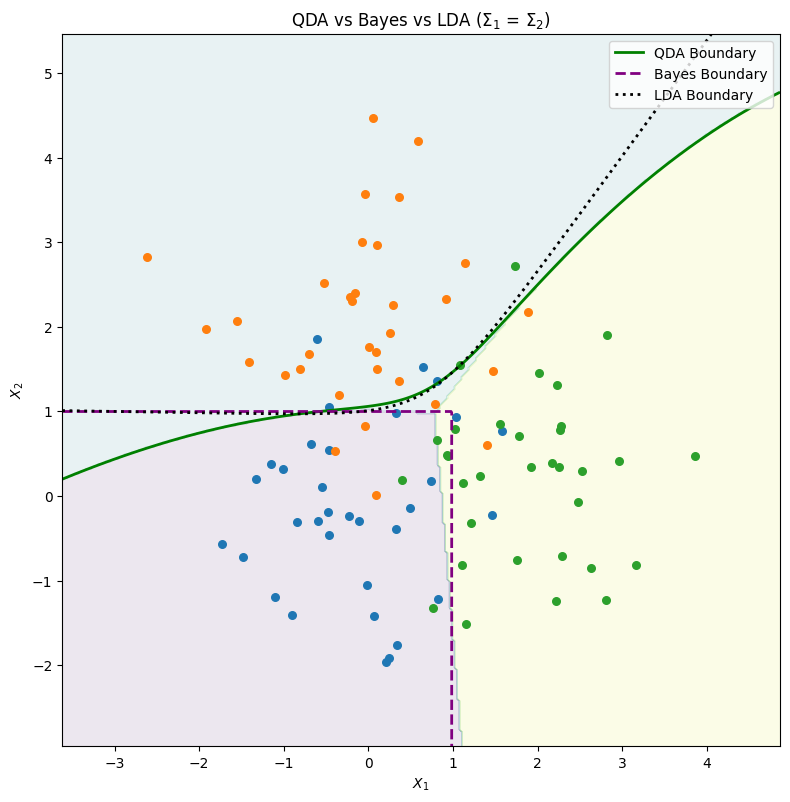

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


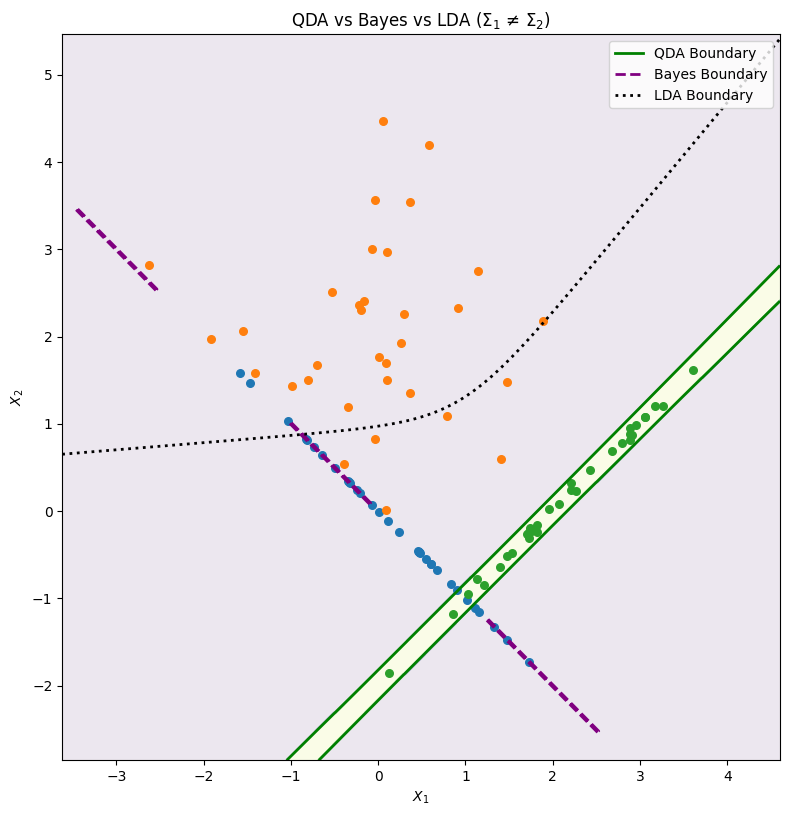

In [13]:
def make_grid(X, pad=1.0):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy

def plot_ellipses_and_lda_vs_bayes(K=3, eta=0.0, n_train=20):
    X, y, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)
    lda = LinearDiscriminantAnalysis().fit(X, y)
    grid, xx, yy = make_grid(X)

    Z_lda = lda.predict(grid).reshape(xx.shape)
    Z_bayes, _ = compute_bayes_predictions(grid, means, shared_cov, class_covs, eta)
    Z_bayes = Z_bayes.reshape(xx.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].contourf(xx, yy, Z_bayes, alpha=0.1)
    draw_ellipses(axs[0], means, shared_cov, class_covs, eta)
    axs[0].contour(xx, yy, Z_bayes, colors='k', linestyles='dashed')
    axs[0].set_title("Ellipses & Bayes Boundary")

    axs[1].contourf(xx, yy, Z_lda, alpha=0.1)
    axs[1].contour(xx, yy, Z_bayes, colors='k', linestyles='dashed')
    axs[1].contour(xx, yy, Z_lda, colors='k')
    for i in range(K):
        axs[1].scatter(X[y == i, 0], X[y == i, 1], s=30)
    axs[1].set_title("LDA vs Bayes")

    custom_lines = [Line2D([0], [0], color='black', linestyle='-'),
                    Line2D([0], [0], color='black', linestyle='dashed')]
    axs[1].legend(custom_lines, ['LDA Boundary', 'Bayes Boundary'], loc='upper right')

    for ax in axs:
        ax.set_xlabel("$X_1$")
        ax.set_ylabel("$X_2$")
    plt.tight_layout()
    plt.show()

def plot_qda_vs_bayes_vs_lda(K=2, n_train=100):
    for eta, title in zip([0.0, 1.0], ["Σ₁ = Σ₂", "Σ₁ ≠ Σ₂"]):
        X, y, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)
        lda = LinearDiscriminantAnalysis().fit(X, y)
        qda = QuadraticDiscriminantAnalysis().fit(X, y)
        grid, xx, yy = make_grid(X)

        # Compute class 1 probabilities
        Z_lda_prob = lda.predict_proba(grid)[:, 1].reshape(xx.shape)
        Z_qda_prob = qda.predict_proba(grid)[:, 1].reshape(xx.shape)
        Z_bayes_prob, _ = compute_bayes_predictions(grid, means, shared_cov, class_covs, eta)
        Z_bayes_prob = Z_bayes_prob.reshape(xx.shape)

        # Plotting
        fig, ax = plt.subplots(figsize=(8,15))

        # Background coloring by predicted QDA class
        Z_qda_class = qda.predict(grid).reshape(xx.shape)
        ax.contourf(xx, yy, Z_qda_class, alpha=0.1)

        # True decision boundaries (at p=0.5)
        ax.contour(xx, yy, Z_qda_prob, levels=[0.5], colors='green', linewidths=2)
        ax.contour(xx, yy, Z_bayes_prob, levels=[0.5], colors='purple', linestyles='--', linewidths=2)
        ax.contour(xx, yy, Z_lda_prob, levels=[0.5], colors='black', linestyles=':', linewidths=2)

        # Scatter training points
        for i in range(K):
            ax.scatter(X[y == i, 0], X[y == i, 1], s=30)

        ax.set_title(f"QDA vs Bayes vs LDA ($\\Sigma_1$ {('=' if eta==0 else '≠')} $\\Sigma_2$)")
        ax.set_xlabel("$X_1$")
        ax.set_ylabel("$X_2$")
        ax.legend([
            Line2D([0], [0], color='green', linewidth=2),
            Line2D([0], [0], color='purple', linestyle='--', linewidth=2),
            Line2D([0], [0], color='black', linestyle=':', linewidth=2)
        ], ['QDA Boundary', 'Bayes Boundary', 'LDA Boundary'], loc='upper right')

        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import seaborn as sns

def plot_qda_vs_bayes_vs_lda_general(K=3, n_train=100, eta=0.5):
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Simulate data
    X, y, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)
    
    # Fit models
    lda = LinearDiscriminantAnalysis().fit(X, y)
    qda = QuadraticDiscriminantAnalysis().fit(X, y)
    
    # Generate grid
    grid, xx, yy = make_grid(X)

    # Get predicted classes for decision boundaries
    Z_lda_class = lda.predict(grid).reshape(xx.shape)
    Z_qda_class = qda.predict(grid).reshape(xx.shape)
    Z_bayes_class, _ = compute_bayes_predictions(grid, means, shared_cov, class_covs, eta)
    Z_bayes_class = Z_bayes_class.reshape(xx.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 25)) 

    
    # QDA background coloring
    ax.contourf(xx, yy, Z_qda_class, alpha=0.1, cmap="Pastel1")

    # Decision boundaries: contour lines where class changes
    levels = np.arange(K + 1) - 0.5
    ax.contour(xx, yy, Z_qda_class, levels=levels, colors='green', linewidths=2)
    ax.contour(xx, yy, Z_bayes_class, levels=levels, colors='purple', linestyles='--', linewidths=2)
    ax.contour(xx, yy, Z_lda_class, levels=levels, colors='black', linestyles=':', linewidths=2)

    # Training points
    colors = sns.color_palette("Set1", K)
    for i in range(K):
        ax.scatter(X[y == i, 0], X[y == i, 1], s=40,
                   label=f"Class {i}", color=colors[i], edgecolor='k', alpha=0.8)

    # Title and labels
    eq_sign = '=' if eta == 0.0 else '≠'
    ax.set_title(f"QDA vs Bayes vs LDA ($\\Sigma_1$ {eq_sign} $\\Sigma_2$)", fontsize=14)
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

    # Legends
    boundary_lines = [
        Line2D([0], [0], color='green', lw=2),
        Line2D([0], [0], color='purple', linestyle='--', lw=2),
        Line2D([0], [0], color='black', linestyle=':', lw=2)
    ]
    class_dots = [Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=colors[i], markeredgecolor='k', markersize=10)
                  for i in range(K)]

    ax.legend(boundary_lines + class_dots,
              ['QDA Boundary', 'Bayes Boundary', 'LDA Boundary'] + [f'Class {i}' for i in range(K)],
              loc='upper right', frameon=True)

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


# Run both plots
plot_ellipses_and_lda_vs_bayes(K=3, eta=0.0, n_train=20)
plot_qda_vs_bayes_vs_lda(K=3, n_train=100)

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


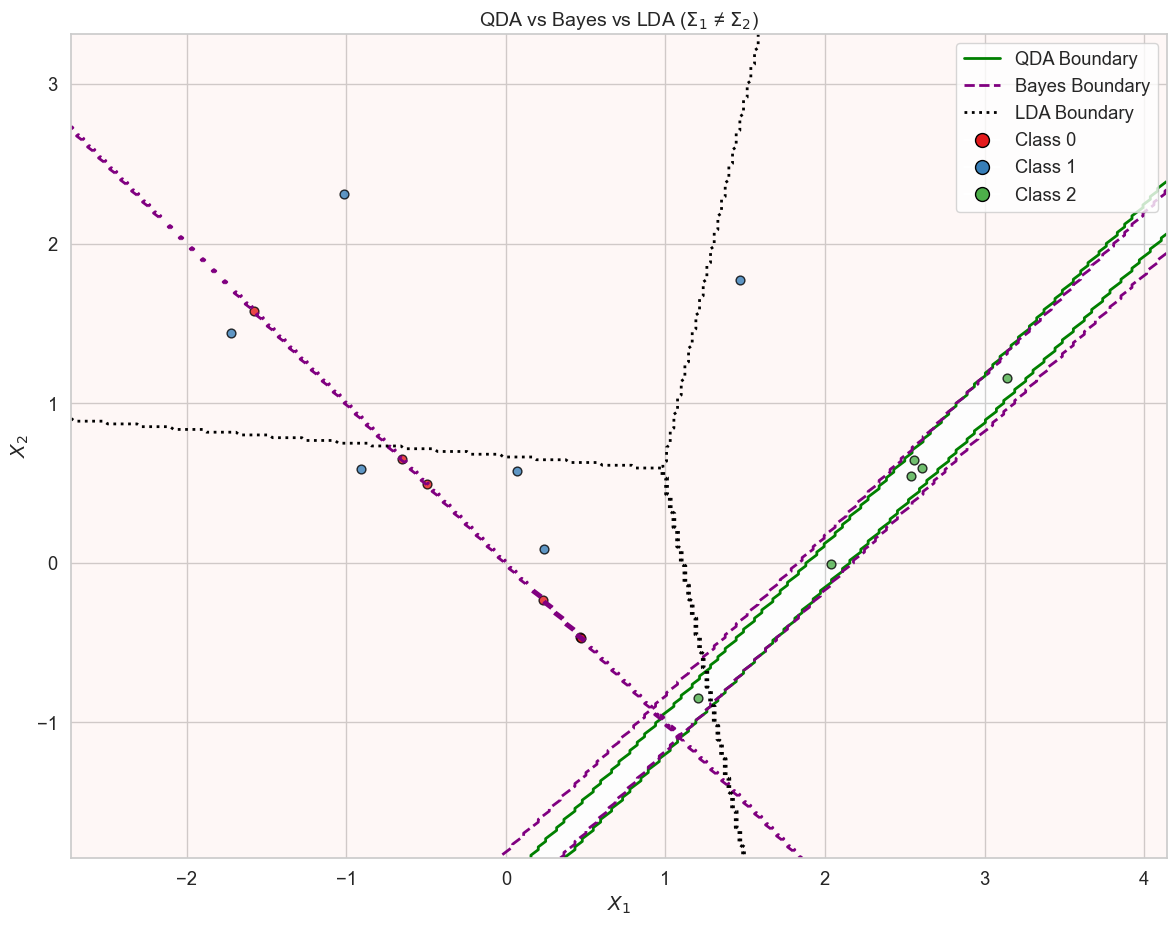

In [14]:
plot_qda_vs_bayes_vs_lda_general(K=3, n_train=20, eta=1)

## Simulation Visualisation 

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

def show_decision_boundaries(K=2, eta=0.5, n_train=50):
    # Simulate data
    X, y, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)

    # Fit LDA and QDA
    lda = LinearDiscriminantAnalysis().fit(X, y)
    qda = QuadraticDiscriminantAnalysis().fit(X, y)

    # Grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get probabilities
    Z_lda_prob = lda.predict_proba(grid)[:, 1].reshape(xx.shape)
    Z_qda_prob = qda.predict_proba(grid)[:, 1].reshape(xx.shape)
    Z_bayes_prob, _ = compute_bayes_predictions(grid, means, shared_cov, class_covs, eta)
    Z_bayes_prob = Z_bayes_prob.reshape(xx.shape)

    # Get class prediction for background
    Z_qda_class = qda.predict(grid).reshape(xx.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(xx, yy, Z_qda_class, alpha=0.1)

    ax.contour(xx, yy, Z_qda_prob, levels=[0.5], colors='green', linewidths=2)
    ax.contour(xx, yy, Z_bayes_prob, levels=[0.5], colors='purple', linestyles='--', linewidths=2)
    ax.contour(xx, yy, Z_lda_prob, levels=[0.5], colors='black', linestyles=':', linewidths=2)

    for i in range(K):
        ax.scatter(X[y == i, 0], X[y == i, 1], s=30, alpha=0.6, label=f"Class {i}")

    ax.set_title(f"QDA vs Bayes vs LDA (η = {eta})")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

    custom_lines = [Line2D([0], [0], color='green', linewidth=2),
                    Line2D([0], [0], color='purple', linestyle='--', linewidth=2),
                    Line2D([0], [0], color='black', linestyle=':', linewidth=2)]
    ax.legend(custom_lines, ['QDA Boundary', 'Bayes Boundary', 'LDA Boundary'], loc='upper right')

    plt.tight_layout()
    plt.show()


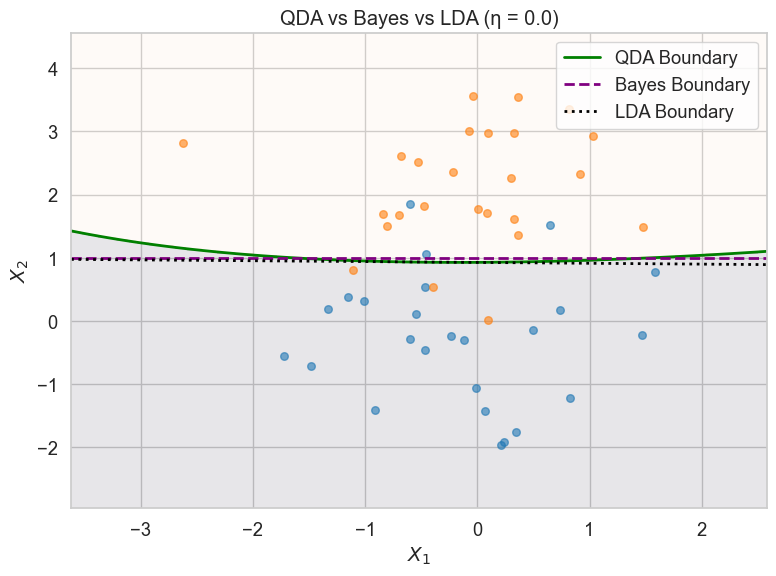

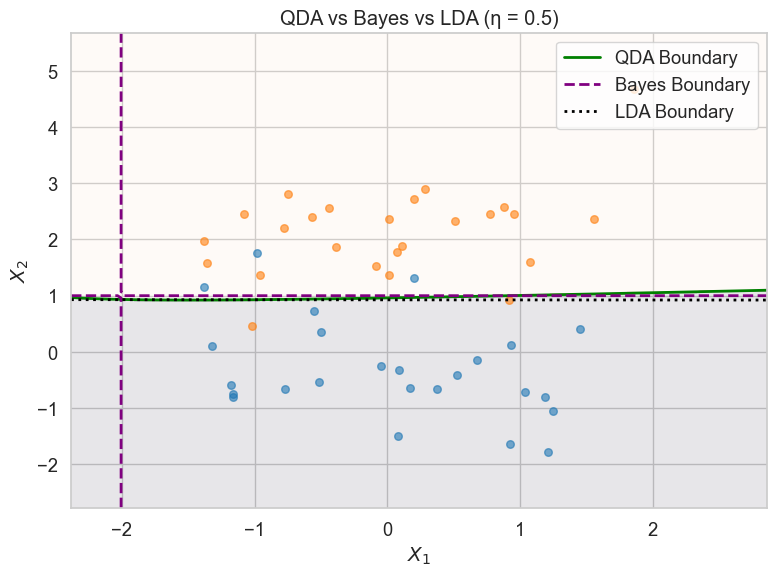

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/var/folders/qp/hpqz59wd00ldpjjnvl_h2t_w0000gn/T/ipykernel_645/158141837.py:16: RuntimeWarning: invalid value encountered in divide
  probs /= probs.sum(axis=1, keepdims=True)


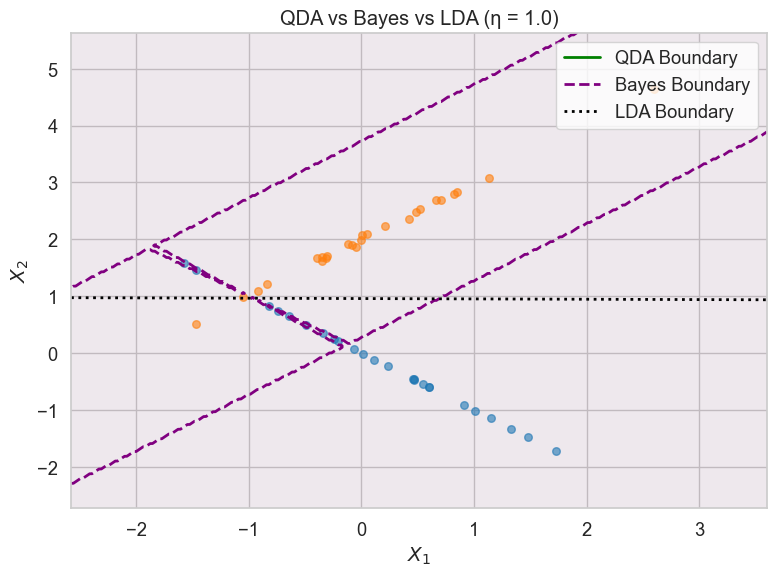

In [16]:
show_decision_boundaries(K=2, eta=0.0, n_train=50)
show_decision_boundaries(K=2, eta=0.5, n_train=50)
show_decision_boundaries(K=2, eta=1.0, n_train=50)


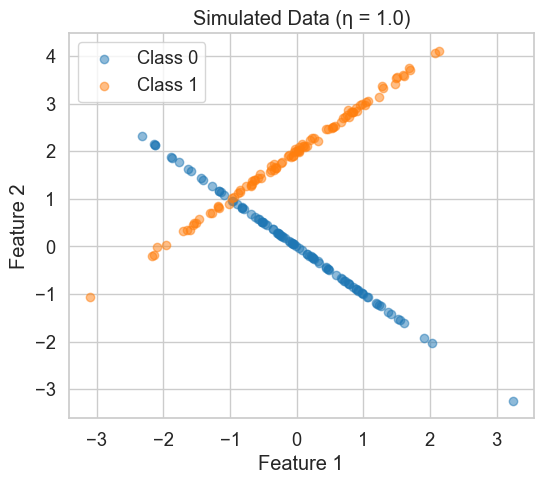

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simulated_data(X, y, title="Simulated Data"):
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)

    plt.figure(figsize=(6, 5))
    for c in classes:
        plt.scatter(X[y == c, 0], X[y == c, 1], label=f"Class {c}", alpha=0.5)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation parameters
k = 2
eta = 1.0
n_train_per_c = 50
n_cal_per_c = 25
n_test_per_c = 25
total_per_class = n_train_per_c + n_cal_per_c + n_test_per_c

# Setup simulation (generates initial data + parameters)
_, _, means, shared_cov, class_covs = setup_simulation(
    K=k,
    eta=eta,
    n_train=n_train_per_c
)

# Generate new data with same parameters (larger set)
X_full, y_full = generate_data(
    n_per_class=total_per_class,
    eta=eta,
    K=k,
    means=means,
    shared_cov=shared_cov,
    class_covs=class_covs
)

# Plot the result
plot_simulated_data(X_full, y_full, title=f"Simulated Data (η = {eta:.1f})")


In [18]:
for cls in np.unique(y_full):
    emp_cov = np.cov(X_full[y_full == cls].T)
    print(f"Class {cls} covariance:\n{emp_cov}\n")


Class 0 covariance:
[[ 1.05819547 -1.05819548]
 [-1.05819548  1.05819548]]

Class 1 covariance:
[[1.09043791 1.08733576]
 [1.08733576 1.08590593]]

